In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import log_loss
import numpy as np

In [2]:
train_set = pd.read_csv('train_prepared.csv', encoding='utf-8')
test_set = pd.read_csv('test_prepared.csv', encoding='utf-8')

In [3]:
train_set.rename(columns={"Pricing, Delivery_Terms_Quote_Appr": "Pricing_Delivery_Terms_Quote_Appr", 
                          "Pricing, Delivery_Terms_Approved": "Pricing_Delivery_Terms_Approved"}, inplace=True)

test_set.rename(columns={"Pricing, Delivery_Terms_Quote_Appr": "Pricing_Delivery_Terms_Quote_Appr", 
                         "Pricing, Delivery_Terms_Approved": "Pricing_Delivery_Terms_Approved"}, inplace=True)

In [4]:
X = train_set.drop(columns=['Target', 'Opportunity_ID'])
y = train_set.Target

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
#con train

#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#classifier = lgb.LGBMClassifier()

#param_grid = {
#    'boosting_type': ['gbdt', 'goss', 'dart'],
#    'num_leaves': list(range(20, 150)),
#    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
#    'subsample_for_bin': list(range(20000, 300000, 20000)),
#    'min_child_samples': list(range(20, 500, 5)),
#    'reg_alpha': list(np.linspace(0, 1)),
#    'reg_lambda': list(np.linspace(0, 1)),
#    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
#    'subsample': list(np.linspace(0.5, 1, 100)),
#}

#random_search=RandomizedSearchCV(classifier,param_distributions=param_grid,n_iter=750, scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)

#random_search.fit(X_train,y_train)

In [7]:
#random_search.best_params_

In [8]:
#random_search.best_score_

In [9]:
best = {'subsample_for_bin': 250000, 'subsample': 0.8131313131313131, 
        'reg_lambda': 0.2857142857142857, 'reg_alpha': 0.18367346938775508, 
        'num_leaves': 35, 'min_child_samples': 87, 'learning_rate': 0.07016445423929361, 
        'colsample_bytree': 0.3, 'boosting_type': 'gbdt'}

In [10]:
classifier = lgb.LGBMClassifier(**best)

classifier.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.3, learning_rate=0.07016445423929361,
               min_child_samples=87, num_leaves=35,
               reg_alpha=0.18367346938775508, reg_lambda=0.2857142857142857,
               subsample=0.8131313131313131, subsample_for_bin=250000)

In [11]:
log_loss(y_test, classifier.predict_proba(X_test))

0.30724381769513703

In [12]:
preds = classifier.predict_proba(test_set.drop(columns=['Opportunity_ID']))
preds

array([[0.13246829, 0.86753171],
       [0.36678173, 0.63321827],
       [0.68851909, 0.31148091],
       ...,
       [0.83613915, 0.16386085],
       [0.35135854, 0.64864146],
       [0.93529714, 0.06470286]])

In [14]:
final = test_set.loc[:, ['Opportunity_ID', 'Target']].copy()
final['Target'] = preds[:, 1]
display(final)
final.to_csv('predictions/lgbm.csv', index=False)

,Opportunity_ID,Target
0,10689,0.867532
1,10690,0.633218
2,10691,0.311481
3,10692,0.347965
4,10693,0.946024
...,...,...
1562,12364,0.976278
1563,12365,0.185317
1564,12366,0.163861
1565,12367,0.648641


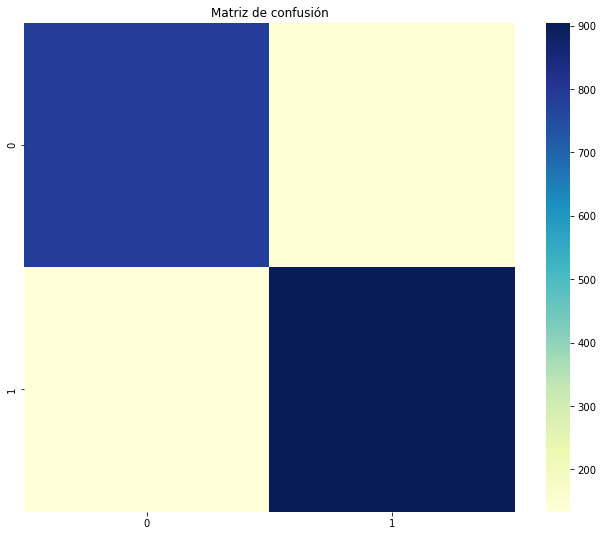

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_test, classifier.predict(X_test)), cmap='YlGnBu')
plt.show()